# Clasificador Redes

## Importamos las librerias a utilizar

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras 

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras import layers



from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from pysentimiento import create_analyzer
import transformers

## Cargamos el df y Preprocesamiento

In [20]:
review = pd.read_csv('datasets/train.csv')
review_analyzed = pd.read_csv('train_500.csv')
review_analyzed['len']=review['review_es'].apply(lambda x: len(x))
review_analyzed['len%']=review_analyzed['len'].apply(lambda x: round(500/x,4))
review_t = pd.read_csv('test_500.csv')
review_t_orig = pd.read_csv('datasets/test.csv')
review_t['len']=review_t_orig['review_es'].apply(lambda x: len(x))
review_t['len%']=review_t['len'].apply(lambda x: round(500/x,4))
review_orig = review_t.copy()
review['sentimiento'] = review['sentimiento'].map({'positivo':1,'negativo':0},na_action=None)
review.drop('ID', axis='columns', inplace=True)
#review_t.drop('ID', axis='columns', inplace=True)
review.head()

,review_es,sentimiento
0,Uno de los otros críticos ha mencionado que de...,1
1,Una pequeña pequeña producción.La técnica de f...,1
2,Pensé que esta era una manera maravillosa de p...,1
3,"Básicamente, hay una familia donde un niño peq...",0
4,"El ""amor en el tiempo"" de Petter Mattei es una...",1


In [21]:
review_analyzed_350 = pd.read_csv('train_350.csv')
review_analyzed['POS_evolution'] =round((review_analyzed['POS'] - review_analyzed_350['POS'] )/review_analyzed_350['POS'],4)
review_analyzed['NEU_evolution'] =round((review_analyzed['NEU'] - review_analyzed_350['NEU'] )/review_analyzed_350['NEU'],4)
review_analyzed['NEG_evolution'] =round((review_analyzed['NEG'] - review_analyzed_350['NEG'] )/review_analyzed_350['NEG'],4)

review_t_350 = pd.read_csv('test_350.csv')
review_t['POS_evolution'] =round((review_t['POS'] - review_t_350['POS'] )/review_t_350['POS'],4)
review_t['NEU_evolution'] =round((review_t['NEU'] - review_t_350['NEU'] )/review_t_350['NEU'],4)
review_t['NEG_evolution'] =round((review_t['NEG'] - review_t_350['NEG'] )/review_t_350['NEG'],4)

review_analyzed.head()

,POS,NEU,NEG,prediccion,len,len%,POS_evolution,NEU_evolution,NEG_evolution
0,0.079080,0.405715,0.515205,False,2004,0.2495,4.4754,2.5544,-0.4088
1,0.958347,0.037944,0.003709,True,1061,0.4713,0.0037,-0.0567,-0.2558
2,0.704222,0.265974,0.029804,True,989,0.5056,-0.2687,6.6667,11.6379
3,0.003202,0.052839,0.943959,False,790,0.6329,-0.1653,-0.4221,0.0434
4,0.837944,0.148898,0.013158,True,1406,0.3556,-0.0728,0.7319,0.2762


In [22]:
review_t.head()

,POS,NEU,NEG,prediccion,len,len%,POS_evolution,NEU_evolution,NEG_evolution
0,0.663744,0.275325,0.060931,True,4620,0.1082,-0.1776,0.7804,0.5920
1,0.003529,0.038735,0.957736,False,1198,0.4174,-0.3082,-0.3548,0.0245
2,0.004528,0.031222,0.964251,False,781,0.6402,0.1886,0.0761,-0.0030
3,0.015060,0.058439,0.926500,False,1868,0.2677,-0.9478,-0.7570,0.9675
4,0.738417,0.195294,0.066289,True,1608,0.3109,0.0326,-0.0675,-0.1214


## Entrenamiento y Prediccion

In [23]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [24]:
review_split = review_analyzed
target='sentimiento'
#review_split = review_split.sample(frac=0.5, random_state=1)
#review_split=review.drop([target], axis='columns', inplace=False)
sentimientos = review[target].copy()
review_split.head()

,POS,NEU,NEG,prediccion,len,len%,POS_evolution,NEU_evolution,NEG_evolution
0,0.079080,0.405715,0.515205,False,2004,0.2495,4.4754,2.5544,-0.4088
1,0.958347,0.037944,0.003709,True,1061,0.4713,0.0037,-0.0567,-0.2558
2,0.704222,0.265974,0.029804,True,989,0.5056,-0.2687,6.6667,11.6379
3,0.003202,0.052839,0.943959,False,790,0.6329,-0.1653,-0.4221,0.0434
4,0.837944,0.148898,0.013158,True,1406,0.3556,-0.0728,0.7319,0.2762


In [25]:
x_train, x_test, y_train, y_test = train_test_split(review_split, 
                                                    sentimientos, 
                                                    test_size=0.10,  
                                                    random_state=50, )
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

45000
5000
45000
5000


In [26]:
stand_scaler = MinMaxScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm=stand_scaler.transform(x_test)

In [27]:
d_in=len(x_train.columns)

model1 = keras.Sequential([
    keras.layers.Dense(128, input_shape=(d_in, ),activation='tanh'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='sigmoid'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='tanh'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(16, activation='sigmoid'),
    keras.layers.Dense(1, activation='relu')
])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 128)               1280      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 16)               

In [28]:
model1.compile(
  loss='mse',
  optimizer='nadam',
  metrics=['acc','mse'], 
)

In [29]:
cant_epochs=300
model = model1.fit(x_train_norm,y_train,epochs=cant_epochs,batch_size=170,verbose=False)

157/157 [==============================] - 1s 2ms/step
[[0.37812078]
 [0.47607604]
 [0.5169856 ]
 ...
 [0.5123874 ]
 [0.4760989 ]
 [0.3539241 ]]
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      2509
           1       0.77      0.77      0.77      2491

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000



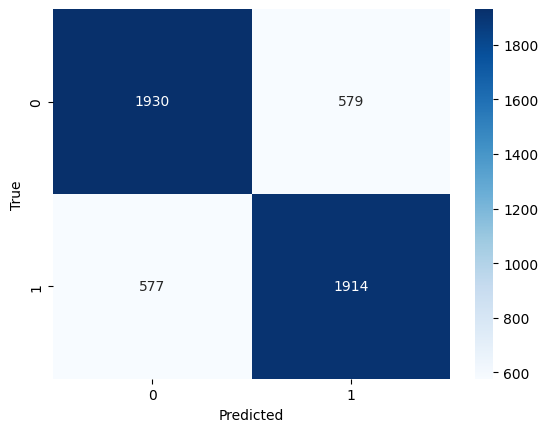

In [30]:
y_predic_ej1 = model1.predict(x_test_norm)
print(y_predic_ej1)
y_predic_cat_ej1 = np.where(y_predic_ej1>0.5,1,0)

ds_validacion=pd.DataFrame(y_predic_cat_ej1,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

metricas(ds_validacion.y_pred, ds_validacion.y_real)

In [31]:
stand_scaler =  MinMaxScaler()
x_norm = stand_scaler.fit_transform(review_t)

In [32]:
y_predic = model1.predict(x_norm)
y_predic_cat = np.where(y_predic>0.5,'positivo','negativo')
print(len(y_predic_cat))

269/269 [==============================] - 1s 2ms/step
8599


In [33]:
array = []
for i in y_predic_cat:
    array.append(i[0])
print(len(array))

8599


In [34]:
entregable = pd.DataFrame({'ID': review_t_orig['ID'], 'sentimiento':pd.Series(array)})

entregable.head()

,ID,sentimiento
0,60000,positivo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,positivo


In [35]:
entregable.to_csv('redes_predictions_tp2.csv', index=False)#redes_prediction7

In [36]:
import pickle
pickle.dump(model, open("redes_tp2", "wb"))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...layers\dense_4
......vars
.........0
.........1
...layers\dense_5
......vars
.........0
.........1
...layers\dense_6
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...metrics\mean_metric_wrapper_1
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........23
.........24
.........25
.........26
.........27
.........28
.........3
.........4
..